### Using news and daily infected

#### No scaling

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

import random


In [24]:
df = pd.read_csv('df_infected_news.csv')
df.rename(columns={"Unnamed: 0": "Date","binary_score (1:good   0: bad)": "Score"}, inplace=True)
#df['Score'] = df['Score'].values.astype(int)
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
print(df.shape)
print(df.dtypes)
df.head()

(1299, 3)
Date        datetime64[ns]
Infected           float64
Score              float64
dtype: object


,Date,Infected,Score
0,2020-08-31,430.0,0.0
1,2020-08-31,430.0,0.0
2,2020-08-31,430.0,0.0
3,2020-08-31,430.0,1.0
4,2020-09-01,624.0,0.0


In [25]:
np.unique(df['Score'], return_counts = True)

(array([0., 1.]), array([1072,  227], dtype=int64))

(array([1072.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         227.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

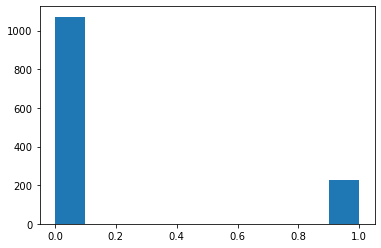

In [26]:
plt.hist(df['Score'])

In [27]:
def rand_score(score):
    if score == 0: 
        return random.randint(1,5) #inclusive
    else: 
        return random.randint(6,10)
    

In [28]:
temp_arr = []
for score in df['Score']:
    temp_arr.append(rand_score(score)*1000) #scaling to avoid gradient explosion

In [29]:
df['Decimal score'] = temp_arr

In [45]:
df.to_csv('df_infected_news_decimal_scaled.csv', index = False)

In [46]:
df

,Date,Infected,Score,Decimal score
0,2020-08-31,430.0,0.0,3000
1,2020-08-31,430.0,0.0,1000
2,2020-08-31,430.0,0.0,3000
3,2020-08-31,430.0,1.0,8000
4,2020-09-01,624.0,0.0,2000
...,...,...,...,...
1295,2021-08-20,25858.0,0.0,4000
1296,2021-08-20,25858.0,0.0,2000
1297,2021-08-20,25858.0,0.0,4000
1298,2021-08-21,25461.0,0.0,1000


(array([218., 200., 211., 243., 200.,  47.,  57.,  47.,  28.,  48.]),
 array([ 1000.,  1900.,  2800.,  3700.,  4600.,  5500.,  6400.,  7300.,
         8200.,  9100., 10000.]),
 <BarContainer object of 10 artists>)

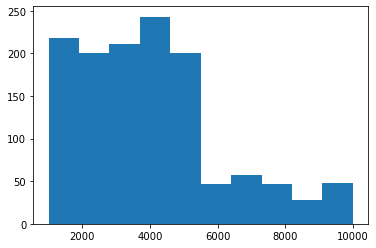

In [31]:
plt.hist(df['Decimal score'])

In [32]:
def split_seq(seq, n_steps_in, n_steps_out):
    X = []
    y = []
    for i in range(len(seq)):
        x_end_idx = i + n_steps_in
        y_end_idx = x_end_idx + n_steps_out
        if(y_end_idx > len(seq)):
            break
        X.append(seq[i:x_end_idx])
        y.append(seq[x_end_idx:y_end_idx])
    return np.array(X), np.array(y)


In [33]:
n_steps_in = 50
n_steps_out = 10

In [34]:
X, y = split_seq(df['Infected'], n_steps_in, n_steps_out)
print(X.shape, y.shape)

(1240, 50) (1240, 10)


In [35]:
X_news, y_news = split_seq(df['Decimal score'], n_steps_in, n_steps_out)
print(X_news.shape, y_news.shape)

(1240, 50) (1240, 10)


In [36]:
X_news

array([[3000, 1000, 3000, ..., 3000, 2000, 1000],
       [1000, 3000, 8000, ..., 2000, 1000, 3000],
       [3000, 8000, 2000, ..., 1000, 3000, 3000],
       ...,
       [3000, 4000, 2000, ..., 3000, 2000, 1000],
       [4000, 2000, 1000, ..., 2000, 1000, 4000],
       [2000, 1000, 1000, ..., 1000, 4000, 4000]], dtype=int64)

### Adding new feature: decimal score

In [37]:
infected_3d = np.expand_dims(X, 2) #3rd demension 
print(infected_3d.shape)
#infected_new_dim

(1240, 50, 1)


In [38]:
news_3d = np.expand_dims(X_news, 2) #3rd demension 
print(news_3d.shape)
#news_new_dim

(1240, 50, 1)


In [39]:
news_new_dim[:,:,0] # just making sure we're on track

array([[2000, 1000, 2000, ..., 1000, 5000, 1000],
       [1000, 2000, 9000, ..., 5000, 1000, 4000],
       [2000, 9000, 5000, ..., 1000, 4000, 5000],
       ...,
       [4000, 1000, 3000, ..., 1000, 1000, 5000],
       [1000, 3000, 2000, ..., 1000, 5000, 2000],
       [3000, 2000, 5000, ..., 5000, 2000, 1000]], dtype=int64)

In [40]:
data_3d = np.append(infected_3d, news_3d, axis =2) #append (1240,50) to the 3rd dimension
print(data_3d.shape) # samples, timesteps, features

(1240, 50, 2)


### Train/test set

In [47]:
split_pnt = 1000

X_train = data_3d[:split_pnt]
X_test = data_3d[split_pnt:]

y_train = y[:split_pnt]
y_test  = y[split_pnt:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1000, 50, 2) (240, 50, 2)
(1000, 10) (240, 10)


In [50]:
input_shape = (X_train.shape[1],X_train.shape[2])
input_shape

(50, 2)

### Model

In [56]:
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, activation='relu', input_shape = input_shape))
model.add(LSTM(units = 100,return_sequences = True,activation='relu'))


model.add(LSTM(units = 100, return_sequences = True, activation='relu'))


model.add(LSTM(units = 100, activation='relu'))

# Adding the output layer
model.add(Dense(units = n_steps_out, activation='tanh'))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')



# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 500, batch_size = 128)

Epoch 1/500
8/8 [==============================] - 2s 275ms/step - loss: 2950.0991
Epoch 2/500
8/8 [==============================] - 2s 297ms/step - loss: 2950.0671
Epoch 3/500
8/8 [==============================] - 2s 281ms/step - loss: 2950.0161
Epoch 4/500
8/8 [==============================] - 2s 281ms/step - loss: 2949.9861
Epoch 5/500
8/8 [==============================] - 2s 276ms/step - loss: 2949.9351
Epoch 6/500
8/8 [==============================] - 2s 291ms/step - loss: 2949.9102
Epoch 7/500
8/8 [==============================] - 2s 283ms/step - loss: 2949.9131
Epoch 8/500
8/8 [==============================] - 2s 275ms/step - loss: 2949.9062
Epoch 9/500
8/8 [==============================] - 2s 275ms/step - loss: 2949.8711
Epoch 10/500
8/8 [==============================] - 2s 274ms/step - loss: 2949.8745
Epoch 11/500
8/8 [==============================] - 2s 277ms/step - loss: 2949.8525
Epoch 12/500
8/8 [==============================] - 2s 279ms/step - loss: 2949.8738
E

KeyboardInterrupt: 